In [5]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, AutoConfig, AutoTokenizer
import torch
from datasets import Dataset, Sequence, ClassLabel, Features, Value

import evaluate
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import random
from torch_scatter import scatter

from preproc.utils import tokenize_and_align, compute_metrics, process_df_into_ds
from preproc.parsing import preprocess
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Preprocessing
First, we will define some paths and constant variables.
+ `DATA_NAME`: The name of the file to use for training
+ `MODE`: It can either be `train` or `test` depending on wether a model already exists or not
+ `PER_DS`: It is the percentage of the dataset that is sampled for training

In [6]:
TRAIN_FILE_NAME = 'en_ewt-up-train.conllu'
TEST_FILE_NAME = 'en_ewt-up-test.conllu'
DEV_FILE_NAME = 'en_ewt-up-dev.conllu'
model_name = 'bert-base-uncased'
MODEL_NAME = 'bert_a3_10ep'
MODE='test'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
PER_DS = 0.1

## 1.1 Calling external libraries
We will call the preprocessing library with the `DATA_NAME` file that we used earlier. It should be located in the `data/raw` path for it to be recongnized. It will go over the the CONLL-U file and create a dataframe with it as well as organize the argument label and repeat the tokes as many times at there are predictes in a given sentence. Consequently, if there are 3 predicates in a sentence, there will be 3 rows with the same token per sentence with a different target label depending on if they are part of the argument or not and which argument they are for that predicate.

Also, during preprocessing the arguments with a `C-` or `R-` prefix will be merged with their respective suffix. We do this as they are *continuous* or *reference* arguments. Meaning that given the interpretation, we could label them to same. The merge is based on [[1]](https://arxiv.org/abs/2210.06408). We have decided to do this as our motivation lies in identified the types of clauses rather than the specific differentiation if it is a reference or a continuation. 

Additionally, we will label predicates as `O`, not an argument.

***
[1]: Jindal, I., Rademaker, A., Tran, K. N., Zhu, H., Kanayama, H., Danilevsky, M., & Li, Y. (2022). PriMeSRL-Eval: A Practical Quality Metric for Semantic Role Labeling Systems Evaluation. arXiv preprint arXiv:2210.06408.
***

In [4]:
filename = TRAIN_FILE_NAME if MODE == 'train' else DEV_FILE_NAME
eval_filename = DEV_FILE_NAME
df, label_list = preprocess(filename, force=True)
eval_df, dev_labels = preprocess(eval_filename, force=True)


Skipping sentence with invalid format
Skipping sentence with invalid format


Let's look at the parsed data in the `Dataframe` format to see what we are dealing with


In [91]:
df

,id,position,token,lemma,pos_u,pos_tag,d_tag,head,dep_tag,is_pred,pred,pred_base,label,sentence_id
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['Al', '-', 'Zaman', ':', 'American', 'forces'...","['Al', '-', 'Zaman', ':', 'american', 'force',...","['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'N...","['NNP', 'HYPH', 'NNP', ':', 'JJ', 'NNS', 'VBD'...","['Number=Sing', '_', 'Number=Sing', '_', 'Degr...","['0', '1', '1', '1', '6', '7', '1', '7', '8', ...","['root', 'punct', 'flat', 'punct', 'amod', 'ns...","[False, False, False, False, False, False, Tru...","['killed', 'killed', 'killed', 'killed', 'kill...","['kill.01', 'kill.01', 'kill.01', 'kill.01', '...","['O', 'O', 'O', 'O', 'O', 'B-ARG0', 'B-V', 'B-...",0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['[', 'This', 'killing', 'of', 'a', 'respected...","['[', 'this', 'killing', 'of', 'a', 'respected...","['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', ...","['-LRB-', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', ...","['_', 'Number=Sing|PronType=Dem', 'Number=Sing...","['10', '3', '10', '7', '7', '7', '3', '10', '1...","['punct', 'det', 'nsubj', 'case', 'det', 'amod...","[False, False, True, False, False, False, Fals...","['killing', 'killing', 'killing', 'killing', '...","['kill.01', 'kill.01', 'kill.01', 'kill.01', '...","['O', 'O', 'B-V', 'O', 'O', 'O', 'B-ARG1', 'O'...",1
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['[', 'This', 'killing', 'of', 'a', 'respected...","['[', 'this', 'killing', 'of', 'a', 'respected...","['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', ...","['-LRB-', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', ...","['_', 'Number=Sing|PronType=Dem', 'Number=Sing...","['10', '3', '10', '7', '7', '7', '3', '10', '1...","['punct', 'det', 'nsubj', 'case', 'det', 'amod...","[False, False, True, False, False, False, Fals...","['be', 'be', 'be', 'be', 'be', 'be', 'be', 'be...","['be.03', 'be.03', 'be.03', 'be.03', 'be.03', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-V'...",1
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['[', 'This', 'killing', 'of', 'a', 'respected...","['[', 'this', 'killing', 'of', 'a', 'respected...","['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', ...","['-LRB-', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', ...","['_', 'Number=Sing|PronType=Dem', 'Number=Sing...","['10', '3', '10', '7', '7', '7', '3', '10', '1...","['punct', 'det', 'nsubj', 'case', 'det', 'amod...","[False, False, True, False, False, False, Fals...","['causing', 'causing', 'causing', 'causing', '...","['cause.01', 'cause.01', 'cause.01', 'cause.01...","['O', 'O', 'B-ARG0', 'O', 'O', 'O', 'O', 'B-AR...",1
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['[', 'This', 'killing', 'of', 'a', 'respected...","['[', 'this', 'killing', 'of', 'a', 'respected...","['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', ...","['-LRB-', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', ...","['_', 'Number=Sing|PronType=Dem', 'Number=Sing...","['10', '3', '10', '7', '7', '7', '3', '10', '1...","['punct', 'det', 'nsubj', 'case', 'det', 'amod...","[False, False, True, False, False, False, Fals...","['come', 'come', 'come', 'come', 'come', 'come...","['come.01', 'come.01', 'come.01', 'come.01', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40357,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","['I', 'will', 'never', 'return', 'there', 'aga...","['I', 'will', 'never', 'return', 'there', 'aga...","['PRON', 'AUX', 'ADV', 'VERB', 'ADV', 'ADV', '...","['PRP', 'MD', 'RB', 'VB', 'RB', 'RB', '-LRB-',...","['Case=Nom|Number=Sing|Person=1|PronType=Prs',...","['4', '4', '4', '0', '4', '4', '4', '10', '10'...","['nsubj', 'aux', '

Now we look at the columns, make sure we have all the correct information

In [21]:
df.columns

Index(['id', 'position', 'token', 'lemma', 'pos_u', 'pos_tag', 'd_tag', 'head',
       'dep_tag', 'is_pred', 'pred', 'pred_base', 'label', 'sentence_id'],
      dtype='object')

Now we want to look at the list of possible labels to be taken

In [5]:
print(len(label_list))
label_list

29


['B-ARG0',
 'B-ARG1',
 'B-ARG1-DSP',
 'B-ARG2',
 'B-ARG3',
 'B-ARG4',
 'B-ARG5',
 'B-ARGA',
 'B-ARGM-ADJ',
 'B-ARGM-ADV',
 'B-ARGM-CAU',
 'B-ARGM-COM',
 'B-ARGM-CXN',
 'B-ARGM-DIR',
 'B-ARGM-DIS',
 'B-ARGM-EXT',
 'B-ARGM-GOL',
 'B-ARGM-LOC',
 'B-ARGM-LVB',
 'B-ARGM-MNR',
 'B-ARGM-MOD',
 'B-ARGM-NEG',
 'B-ARGM-PRD',
 'B-ARGM-PRP',
 'B-ARGM-PRR',
 'B-ARGM-REC',
 'B-ARGM-TMP',
 'B-V',
 'O']

## 1.2 Dataset construction
The `huggingface` set of libraries provides a very good wrapper for processing datasets. For that reason, we will transform our data to that format by giving the types of the `features` and then passing our raw data to it

In [4]:
features = Features({
    'id': Sequence(feature=Value('float32')),
    'position': Sequence(feature=Value('float32')),
    'token': Sequence(feature=Value('string')),
    'lemma': Sequence(feature=Value('string')),
    'pos_u': Sequence(feature=Value('string')),
    'pos_tag': Sequence(feature=Value('string')),
    'd_tag': Sequence(feature=Value('string')),
    'head': Sequence(feature=Value('string')),
    'dep_tag': Sequence(feature=Value('string')),
    'is_pred': Sequence(feature=Value('bool')),
    'pred': Sequence(feature=Value('string')),
    'pred_base': Sequence(feature=Value('string')),
    'label': Sequence(feature=ClassLabel(names=label_list)),
    'sentence_id': Value('int32'),

})

ds = Dataset.from_pandas(df[list(features.keys())], features=features)
eval_ds = Dataset.from_pandas(eval_df[list(features.keys())], features=features)


NameError: name 'label_list' is not defined

# 1.4 Dataset filtering
Here we sample $k$ observations uniformly from the dataset, where $k=N*\alpha$ and $\alpha$ is `PER_DS` or the porcentage of the dataset we want to use for training. This
part is for debugging and testing purpouses, `PER_DS` should be set to $1$ generally

In [24]:
ds = ds.select(random.sample(range(len(ds)), int(len(ds)*PER_DS)))
len(ds)

4036

# 1.5 Tokenization 
To perform tokenization we use the BERT base tokenizer from the `distillbert-base-uncased` model, so that is the standard BERT implementation without separate tokens for word cases. 

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, do_basic_tokenize=False)
SEP_TOKEN_ID = tokenizer.all_special_ids[tokenizer.all_special_tokens.index('[SEP]')]

# 2 Model
Our choice of model is based on NegBERT [[1]](https://arxiv.org/abs/1911.04211).  NegBERT uses an annotation schema where certain groups of words are anotated of the labels with the aim of incorporating more information about *negation cues* into the model. According to the authors, this would in turn allow for better cue detection and span detection. We propose a similar modification, in addition to using the `token_type_id` to tag only the predicate in the sentence. Our goal is to desambiguate the use of a prediate that could mean different things. The template for the input is : `[CLS] sent [SEP] pred [SEP]`

To do this we only need to modify our existing utility function for creating the tokenized dataset and add some more steps to it. With that, we just change the following

***
[1]: Khandelwal, A., & Sawant, S. (2019). NegBERT: a transfer learning approach for negation detection and scope resolution. arXiv preprint arXiv:1911.04211.

***

## 2.1 Model tokenization

Calling our tokenization and alignment function on our datasets. Note that we will set the indices of the tokens that were split by *wordpiece* in a separate tensor to evaluate based on the **average** distribution accross different worpieces composing a token. This approach was also introduced in NegBERT.

In [79]:
tokenized_datasets = ds.map(lambda x: tokenize_and_align(tokenizer, x))
eval_tokenized_dataset = eval_ds.map(lambda x: tokenize_and_align(tokenizer, x))
labels = tokenized_datasets.features['label'].feature.names
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

Map:   0%|          | 0/40362 [00:00<?, ? examples/s]

Map:   0%|          | 0/4976 [00:00<?, ? examples/s]

## 2.2 Parameters 
Now we set the model paramets and create the `TrainingArguments` object. We are using a standard `BATCH_SIZE` and a corresponding `LR` (learning rate). We will fine-tune for 2 `EPOCH`s.

In [27]:
task = 'SRL'
BATCH_SIZE = 32
LR = 2e-5
EPOCHS = 2
WEIGHT_DECAY = 0.01

args = TrainingArguments(
    MODEL_NAME,
    evaluation_strategy = "epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=False,
    save_strategy='no',
    use_cpu=True if device == 'cpu' else False,
)


## 2.3 Model creation

We initialize the model, set the labels and give the collator our tokenizer.

In [80]:
config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label)
model = AutoModelForTokenClassification.from_pretrained(model_name, config=config).to(device)
data_collator = DataCollatorForTokenClassification(tokenizer)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we remove useless columns from our dataset and create the `Trainer` object for training our dataset, only if `MODE` is set to train will actually perform training.

## 2.4 Model Training

In [29]:
train_td = tokenized_datasets.remove_columns(ds.column_names)
eval_td = eval_tokenized_dataset.remove_columns(eval_ds.column_names)

trainer = Trainer(
    model,
    args,
    train_dataset=train_td,
    eval_dataset=eval_td,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, config.id2label),
)

if MODE == 'train':
    trainer.train()
    trainer.save_model(MODEL_NAME)


/Users/martincarrasco/miniconda3/envs/anlp/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

/Users/martincarrasco/miniconda3/envs/anlp/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4152999818325043, 'eval_precision': 0.7348844830411273, 'eval_recall': 0.3410127737226277, 'eval_f1': 0.46585302518826277, 'eval_accuracy': 0.9094068862693938, 'eval_runtime': 25.1011, 'eval_samples_per_second': 160.79, 'eval_steps_per_second': 5.06, 'epoch': 1.0}


  0%|          | 0/127 [00:00<?, ?it/s]

{'eval_loss': 0.32994168996810913, 'eval_precision': 0.7101096224116931, 'eval_recall': 0.4876064476885645, 'eval_f1': 0.5781905062435199, 'eval_accuracy': 0.9264128966127755, 'eval_runtime': 43.9152, 'eval_samples_per_second': 91.904, 'eval_steps_per_second': 2.892, 'epoch': 2.0}
{'train_runtime': 187.3122, 'train_samples_per_second': 43.094, 'train_steps_per_second': 1.356, 'train_loss': 0.6472948329655204, 'epoch': 2.0}


# 3.1 Results
To evaluate our results first we load the tokenizer for our model named `MODEL_NAME` (available locally) and tokenize our dataset. This will be the test dataset

 

In [7]:
MODEL_NAME = MODEL_NAME
filename =  TEST_FILE_NAME 

REMOTE = True 
MODEL_URL = MODEL_NAME
if REMOTE:
    MODEL_URL = f"martincc98/{MODEL_NAME}"

tokenizer = AutoTokenizer.from_pretrained(MODEL_URL, local_files_only=not REMOTE)
config = AutoConfig.from_pretrained(MODEL_URL, local_files_only=not REMOTE)
trained_model = AutoModelForTokenClassification.from_pretrained(MODEL_URL, local_files_only=not REMOTE, config=config).to(device)

In [8]:
test_ds = process_df_into_ds(filename, list(config.label2id.keys()))
test_tokenized_datasets = test_ds.map(lambda x: tokenize_and_align(tokenizer, x))

Skipping sentence with invalid format


Map:   0%|          | 0/4791 [00:00<?, ? examples/s]

In [9]:
[config.id2label[l]  for l in test_tokenized_datasets['label'][1]]

['O',
 'O',
 'B-ARG0',
 'B-V',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ARG1',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ARG4',
 'O']

Now we load our already trained model

## Testing on two examples

We know sample two sentences from the dataset and query the model for the classification of their tokens

In [10]:
sent_1 = test_ds[0]
sent_2 = test_ds[1]

print(sent_1['token'])
print(sent_2['token'])

['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?']
['What', 'if', 'Google', 'expanded', 'on', 'its', 'search', '-', 'engine', '(', 'and', 'now', 'e-mail', ')', 'wares', 'into', 'a', 'full', '-', 'fledged', 'operating', 'system', '?']


Now we look at the predicates

In [11]:
print(set(sent_1['pred']))
print(set(sent_2['pred']))

{'Morphed'}
{'expanded'}


Let's look at the tokenized versions

In [12]:
print(tokenizer.convert_ids_to_tokens(list(test_tokenized_datasets[0]['input_ids'])[:20]))
print(tokenizer.convert_ids_to_tokens(list(test_tokenized_datasets[1]['input_ids'])[:30]))

['[CLS]', 'what', 'if', 'google', 'mor', '##ph', '##ed', 'into', 'google', '##os', '?', '[SEP]', 'mor', '##ph', '##ed', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'what', 'if', 'google', 'expanded', 'on', 'its', 'search', '-', 'engine', '(', 'and', 'now', 'e', '-', 'mail', ')', 'ware', '##s', 'into', 'a', 'full', '-', 'fledged', 'operating', 'system', '?', '[SEP]', 'expanded', '[SEP]']


Now let's look at the `true` labels. We will set the label `-100` to `NULL` because it represents a token we will not take into account for classification.

In [13]:
print([config.id2label[l] if l >= 0 else 'NULL' for l in test_tokenized_datasets['labels'][0][:12]])
print([config.id2label[l] if l >= 0 else 'NULL' for l in test_tokenized_datasets['labels'][1][:28]])

['NULL', 'O', 'O', 'B-ARG1', 'B-V', 'B-V', 'B-V', 'O', 'B-ARG2', 'B-ARG2', 'O', 'NULL']
['NULL', 'O', 'O', 'B-ARG0', 'B-V', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG4', 'O', 'NULL']


Now we will see the output of these 2 particular sentences

In [14]:
output_1 = ouptut_2 = None
with torch.inference_mode():
    test_tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label', 'token_type_ids', 'scatter_idx'])
    input_ids = test_tokenized_datasets['input_ids'][:2].to(device)#[:100]#.expand(1, -1)
    attention_mask = test_tokenized_datasets['attention_mask'][:2].to(device)#[:100]#.expand(1, -1)
    token_type_ids = test_tokenized_datasets['token_type_ids'][:2].to(device)#[:100]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
    scatter_idx = test_tokenized_datasets['scatter_idx'][:2].to(device)
    # Average predictions for tokens
    #predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()

    #predictions = predicted_token_class_ids
    labels = test_tokenized_datasets['labels'][:2]#[:100]
    proc_y_true = []
    proc_y_pred = []

    for logits, label, scatter_idx in zip(logits, labels, scatter_idx):
        prediction = scatter(logits, scatter_idx, dim=0, reduce='mean')
        prediction = torch.argmax(prediction, dim=1)
        t_label = scatter(torch.tensor(label).to(device), scatter_idx, dim=0, reduce='max')
        for p, l in zip(prediction, t_label):
            if l != -100:
                proc_y_true.append(l.item())
                proc_y_pred.append(p.item())

    true_labels = proc_y_true
    true_predictions = proc_y_pred 



Now we retrieve the predicted class labels for the indices that do not have `-100`. We run an accuracy metric and then see the results

In [15]:
from evaluate import load
l_t_p = []
l_t_l = []
# for prediction, label in zip(predictions, labels):
#     for p, l in zip(prediction, label):
#         if l != -100:
#             l_t_l.append(l)
#             l_t_p.append(p.item())
    
metric = load("accuracy")
results = metric.compute(predictions=true_predictions, references=true_labels)
print(results)

{'accuracy': 0.96875}


In [16]:
# Predicted
print([config.id2label[l] for l in true_predictions])
# True label
print([config.id2label[l.item()] for l in true_labels])

['O', 'O', 'B-ARG1', 'B-V', 'O', 'B-ARG2', 'O', 'O', 'O', 'B-ARG0', 'B-V', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARGM-GOL', 'O']
['O', 'O', 'B-ARG1', 'B-V', 'O', 'B-ARG2', 'O', 'O', 'O', 'B-ARG0', 'B-V', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARG4', 'O']


## Testing on the whole dataset
Run the following cell to test on the whole dataset and produce results

In [1]:
with torch.inference_mode():

    test_tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label', 'token_type_ids', 'scatter_idx'])
    input_ids = test_tokenized_datasets['input_ids'][:].to(device)#[:100]#.expand(1, -1)
    attention_mask = test_tokenized_datasets['attention_mask'][:].to(device)#[:100]#.expand(1, -1)
    token_type_ids = test_tokenized_datasets['token_type_ids'][:].to(device)#[:100]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
    scatter_idx = test_tokenized_datasets['scatter_idx'][:].to(device)
    #predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()


    #predictions = predicted_token_class_ids
    labels = test_tokenized_datasets['labels'][:]#[:100]
    proc_y_true = []
    proc_y_pred = []

    torch.save(logits, 'data/outputs/logits.pt')
    for logits, label, scatter_idx in zip(logits, labels, scatter_idx):
        prediction = scatter(logits, scatter_idx, dim=0, reduce='mean')
        prediction = torch.argmax(prediction, dim=1)
        t_label = scatter(torch.tensor(label).to(device), scatter_idx, dim=0, reduce='max')
        for p, l in zip(prediction, t_label):
            if l != -100:
                proc_y_true.append(config.id2label[l.item()])
                proc_y_pred.append(config.id2label[p.item()])

    torch.save(proc_y_pred, 'data/outputs/predictions.pt')
    torch.save(proc_y_true, 'data/outputs/labels.pt')
    true_labels = proc_y_true
    true_predictions = proc_y_pred 

    cr = classification_report(true_labels, true_predictions, labels=list(label2id.keys()), zero_division=0, output_dict=True)
    df = pd.DataFrame.from_dict(cr)
    df.to_csv(f'{MODEL_NAME}.csv')

NameError: name 'torch' is not defined

By looking at the plot below we can see that the overall averages both in terms of **weighted** and **macro** averages are worse than before. That will be reflected in the individual cells. Note that in the Figure, the *precision* for `ARGM-TMP` and `ARGM-ADV` is higher than with the baseline model. Consequently, the *recall* scores are much lower. Additionally `ARGM-CAU` no longer has any predictions and the average **macro** for *F1* is lower than the baseline.

<Axes: >

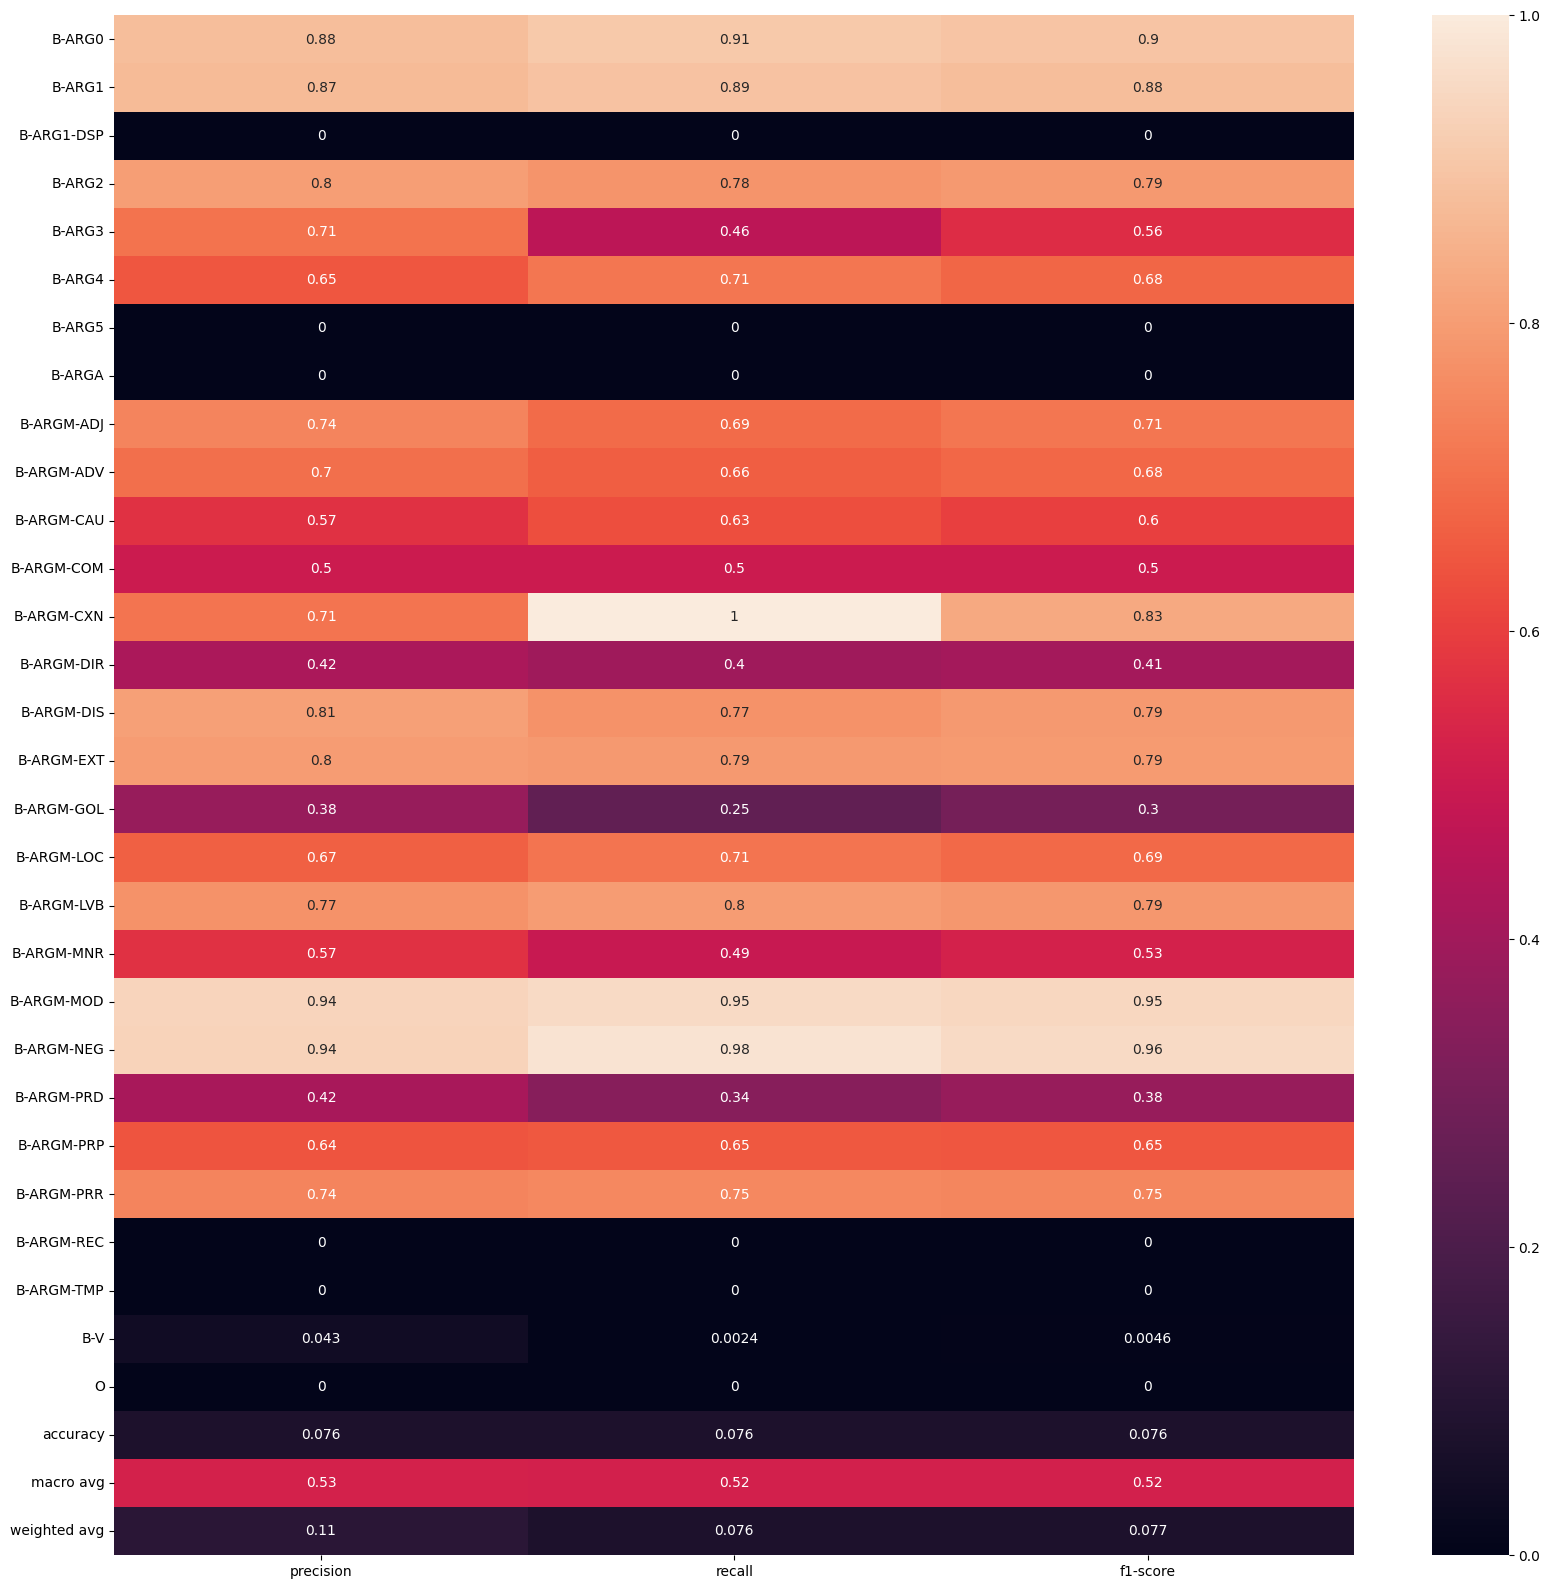

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 20]
df = pd.read_csv(f'bert_a3_10ep.csv', index_col=0)
sns.heatmap(df.iloc[:-1, :].T, annot=True)

# 5 Discussion and Conclusions

We implemeted two versions of the `distilBERT` model, a distilled version of `BERT` that trains and infers faster while retaining a $97%$ of performance. We preprocessed the `PropBank` dataset for english in `CONLL-U` format to feed the training to the models. Our first model is a baseline comparison point of `BERT`, using the *question/answer* tokenization schema where the *question* is the sentence and *answer* is the predicate of the sentence. While performing relatively well on the training set, the test set performance proved to be very low on the task of argument classification. The next model, a similar version but that also encoded the lemmatized version of the predicate and an indicator number according to meaning in the *answer* part of the tokenization schema performed somewhat similarly. It showed very good indentification scores but poor classification power in many arguments.

As we saw in the previous section, the distribution over the test dataset of the arguments is very different from the training set. For this, we believe the model was not able to correctly capture the required information of the training data to generalize and thus it does poorly and the classification task. While it does perform very well at identifyin if a token is an argument or not, we believe that there is further work to do on this matter. Providing the input with more argument information would be a way to augment the information the model has about arguments. Also, experimenting with hyperparameter tunning or just chaning batch sizes and learning rate might influence the output. As the model seems to be overfitting, maybe an intermediate model along the training generalizes better. While testing on the development set we found that a model training on that small set has better classification scores of `ARG0`, `ARG1` and `ARG2`.